## Nearest Neighbor Classifier

### rely

In [11]:
import os
import numpy as np
import pickle
from tqdm.notebook import trange, tqdm
import platform
import torch
import matplotlib.pyplot as plt 

### model

In [12]:
class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        self.Xtr = torch.from_numpy(X).to(device)
        self.ytr = torch.from_numpy(y).to(device)

    def predict(self, X, loop=1, k=1):
        if loop==1:
                return self.L1_distance(X, k)
        elif loop==2:
                return self.L2_distance(X, k)
        
    def L1_distance(self, X, k=1):
        X = torch.from_numpy(X).to(device)
        num_test = X.shape[0]
        Ypred = torch.zeros(num_test, dtype = self.ytr.dtype, device=device)
        for i in trange(num_test):
            distances = torch.sum(torch.abs(self.Xtr - X[i,:]), dim = 1)
            if k==1:
                min_index = torch.argmin(distances)
            else:
                min_indices = torch.topk(distances, k, largest=False).indices
                nearest_classes = self.ytr[min_indices]
                mode_value, _ = torch.mode(nearest_classes, dim=0)
                min_index = mode_value.item()
            Ypred[i] = self.ytr[min_index]
        return Ypred.cpu().numpy()
    
    
    def L2_distance(self, X, k=1):
        X = torch.from_numpy(X).to(device)
        num_test = X.shape[0]
        Ypred = torch.zeros(num_test, dtype = self.ytr.dtype, device=device)
        for i in trange(num_test):
            distances = torch.sqrt(torch.sum(torch.square(self.Xtr - X[i,:]), dim = 1))
            if k==1:
                min_index = torch.argmin(distances)
            else:
                min_indices = torch.topk(distances, k, largest=False).indices
                nearest_classes = self.ytr[min_indices]
                mode_value, _ = torch.mode(nearest_classes, dim=0)
                min_index = mode_value.item()
            Ypred[i] = self.ytr[min_index]
        return Ypred.cpu().numpy()

### load data

In [13]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte 

### main-L1

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xtr, Ytr, Xte, Yte = load_CIFAR10('./data/cifar10')
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3)
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3)
with torch.no_grad():
    nn = NearestNeighbor()
    nn.train(Xtr_rows, Ytr)
    Yte_predict = nn.predict(Xte_rows)
print ('accuracy: %f' % ( np.mean(Yte_predict == Yte) ))

  0%|          | 0/10000 [00:00<?, ?it/s]

accuracy: 0.385900


### main-L2

In [15]:
with torch.no_grad():
    nn = NearestNeighbor()
    nn.train(Xtr_rows, Ytr)
    Yte_predict = nn.predict(Xte_rows, loop=2)
print ('accuracy: %f' % ( np.mean(Yte_predict == Yte) ))

  0%|          | 0/10000 [00:00<?, ?it/s]

accuracy: 0.353900


### 使用49000个训练图像进行训练，并留出1000个用于验证.
### 该验证集本质上用作假测试集来调整超参数

  0%|          | 0/1000 [00:00<?, ?it/s]

accuracy: 0.381000


  0%|          | 0/1000 [00:00<?, ?it/s]

accuracy: 0.108000


  0%|          | 0/1000 [00:00<?, ?it/s]

accuracy: 0.098000


  0%|          | 0/1000 [00:00<?, ?it/s]

accuracy: 0.096000


  0%|          | 0/1000 [00:00<?, ?it/s]

accuracy: 0.096000


  0%|          | 0/1000 [00:00<?, ?it/s]

accuracy: 0.102000


  0%|          | 0/1000 [00:00<?, ?it/s]

accuracy: 0.090000


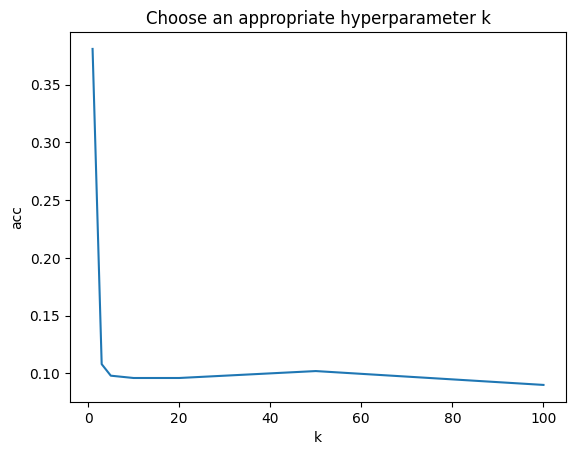

In [16]:
Xval_rows = Xtr_rows[:1000, :]
Yval = Ytr[:1000]
Xtr_rows = Xtr_rows[1000:, :]
Ytr = Ytr[1000:]

k_values = [1, 3, 5, 10, 20, 50, 100]
validation_accuracies = []
for k in k_values:
    nn = NearestNeighbor()
    nn.train(Xtr_rows, Ytr)
    Yval_predict = nn.predict(Xval_rows, k = k)
    acc = np.mean(Yval_predict == Yval)
    print ('accuracy: %f' % (acc))
    validation_accuracies.append(acc)
plt.plot(k_values, validation_accuracies)
plt.xlabel('k')
plt.ylabel('acc')
plt.title('Choose an appropriate hyperparameter k')
plt.show()